<div class="alert alert-block alert-info">
Load Data
</div>

In [1]:
using CSV, DataFrames, Dates, HiGHS, JuMP

In [2]:
df = CSV.read("data.csv", DataFrame)
D_t = df[!, "FR_load_forecast_entsoe_transparency"]

println(size(D_t))
println(first(D_t, 5))

(8760,)
[56250.0, 54300.0, 53600.0, 50000.0, 47100.0]


In [3]:
file_path = "capacity_pv.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_pv = Array(df)
println(first(capacity_pv, 10))
    
file_path = "capacity_wind.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_wind = Array(df)
println(first(capacity_wind, 10))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.067, 0.218]
[0.12594, 0.123693, 0.124232, 0.13045, 0.140045, 0.136766, 0.129185, 0.135791, 0.152821, 0.14136]


<div class="alert alert-block alert-info">
Constant and data
</div>

In [7]:
# Constants and Data
hours_per_year = 8760
lambda = 5000  
cost_of_debt = 0.04
cost_of_equity = 0.07
corporate_tax = 0.30
economic_life = 20
carbon_tax = 50 


capacity = Dict(
    "Coal" => 1,
    "CCGT" => 1,
    "OCGT" => 1,
    "Onshore Wind" => capacity_wind,
    "Offshore Wind" => capacity_wind,
    "PV" => capacity_pv
)

# Technologies data
technologies = Dict(
    "Coal" => (capex=2000*1000, om=0.03, debt_ratio=0.62, heat_rate=2.4, EA=175.2252157*1000, price =5, C=12, emissions=1.4),
    "CCGT" => (capex=950*1000, om=0.03, debt_ratio=0.56, heat_rate=1.62, EA=85.60445144*1000, price =30, C=48.6, emissions=0.5),
    "OCGT" => (capex=700*1000, om=0.03, debt_ratio=0.6, heat_rate=2.5, EA=61.91153839*1000, price =30, C=75, emissions=0.6),
    "Onshore Wind" => (capex=700*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=58.99797384*1000, price =0, C=0, emissions=0.0),
    "Offshore Wind" => (capex=1300*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=109.5676657*1000, price =0, C=0, emissions=0.0),
    "PV" => (capex=400*1000, om=0.03, debt_ratio=0.8, heat_rate=0, EA=32.04823387*1000, price =0, C=0, emissions=0.0)
)

#Battery data
F_b=6*1000
A_b=1.620627574*1000
eta=0.9

0.9

<div class="alert alert-block alert-info">
Question 13
</div>

In [8]:
T = 8760
model = Model(HiGHS.Optimizer)


@variable(model, k[g in keys(technologies)] >= 0)  # Installed capacity
@variable(model, p[g in keys(technologies), t=1:T] >= 0)  # Hourly production
@variable(model, d[t=1:T] >=0)
#For Battery
@variable(model, k_b>=0 ) 
@variable(model, e[1:T] >= 0)
@variable(model, p_in[1:T] >=0)
@variable(model, p_out[1:T] >=0)


@objective(model, Min, sum((technologies[g].om * technologies[g].capex + technologies[g].EA )*k[g] + sum(technologies[g].C*p[g,t]  for t in 1:T) for g in keys(technologies))+ (A_b + F_b)* k_b - sum( lambda * d[t] for t in 1:T)
+ carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:hours_per_year) for g in keys(technologies)))

@constraint(model, [ g in keys(technologies), t in 1:T], p[g,t] <= k[g])
@constraint(model, [t in 1:T], d[t]<=D_t[t])
@constraint(model, [t in 1:T], -d[t] + p_out[t] - p_in[t]  + sum( p[g,t] for g in keys(technologies))==0)
@constraint(model, [t in 1:T], e[t]<= 4*k_b)
@constraint(model, [t in 1:T], p_in[t]<=k_b)
@constraint(model, [t in 1:T], p_out[t]<=k_b)
@constraint(model,  e[1]==0)
@constraint(model, [t in 2:T], e[t]== e[t-1] + 1*(sqrt(eta)* p_in[t-1] - 1/sqrt(eta) * p_out[t-1]))
for g in ["Coal", "CCGT", "OCGT"]
    @constraint(model, [t in 1:T], p[g, t] <= k[g])
end
for t in 1:T
    @constraint(model, p["Onshore Wind", t] <= capacity_wind[t]*k["Onshore Wind"])
    @constraint(model, p["Offshore Wind", t] <= capacity_wind[t]*k["Offshore Wind"])
    @constraint(model, p["PV", t] <= capacity_pv[t]*k["PV"])
end

optimize!(model)
# print("Variables value, p:",JuMP.value.(p))
print("Variables value, k:",value.(k))
print("Variables value, k_b:",value.(k_b))
# print("Variables value, d:",value.(d))
print("Objective value: ", objective_value(model))
print(keys(technologies))
                    
######################################################################################################################
println("\n")

println("\n")
println("Point I")
println("Optimal capacities (kW):")
total_production = 0
production_by_tech = Dict(g => 0.0 for g in keys(technologies))
for g in keys(technologies)
    cap = value(k[g])  # This ensures 'cap' remains a floating-point number
    println("$(g): $(cap) kW")
    for t in 1:hours_per_year
        production_by_tech[g] += value(p[g, t])  # Accumulate as floating-point values
        total_production += value(p[g, t])  # Keep total production as floating-point
    end
end

println("\n")

println("Point II")
println("Share of each technology in effective production:")
for g in keys(technologies)
    share = production_by_tech[g] / total_production
    println("$(g): $(share * 100) %")
end
println("\n")


println("Point III")
println("Total Production: $(total_production) MWh")
total_cost = objective_value(model)
println("Total Investment and Production Cost: €$(total_cost)")
println("\n")


println("Point IV")
# CO2 Emissions data
emissions = Dict(
    "Coal" => 1.4,
    "CCGT" => 0.5,
    "OCGT" => 0.6,
    "Onshore Wind" => 0.0,
    "Offshore Wind" => 0.0,
    "PV" => 0.0
)

# Calculating CO2 emissionys
total_co2_emissions = sum(emissions[g] * production_by_tech[g] for g in keys(production_by_tech))
println("\nTotal CO2 Emissions: $(total_co2_emissions) tons")
println("\n")


println("Point V")
load_curtailment = sum(max(0, D_t[t] - sum(value(p[g, t]) for g in keys(technologies))) for t in 1:hours_per_year)
println("Total Load Curtailment: $(load_curtailment) MWh")
println("\n")


println("Point VI")
# Profit calculation per technology
profit_by_tech = Dict()
for g in keys(technologies)
    revenue = lambda * production_by_tech[g]  # Assuming all production is sold at threshold price λ
    cost = technologies[g].capex * value(k[g]) + technologies[g].om * technologies[g].capex * value(k[g]) / economic_life
    profit_by_tech[g] = revenue - cost
end

println("\nProfit by Technology:")
for g in keys(profit_by_tech)
    println("$(g): €$(profit_by_tech[g])")
end

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
144812 rows, 83500 cols, 360249 nonzeros
114425 rows, 83499 cols, 303581 nonzeros
Presolve : Reductions: rows 114425(-43255); columns 83499(-4108); elements 303581(-77750)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
       7447    -2.3497265459e+12 Pr: 11737(3.04387e+09); Du: 0(6.69298e-07) 6s
      12867    -2.3484957070e+12 Pr: 12763(1.07977e+10); Du: 0(5.23722e-07) 12s
      16216    -2.3484949375e+12 Pr: 13205(4.05509e+10); Du: 0(3.79356e-07) 18s
      18675    -2.3484941604e+12 Pr: 13629(7.00776e+10); Du: 0(3.75177e-07) 24s
      25752    -2.3380412976e+12 Pr: 9817(2.12001e+08); Du: 0(5.051e-07) 29s
      42097    -2.3353902508e+12 Pr: 26536(8.86479e+10); Du: 0(2.71186e-07) 35s
      50580    -2.3344511668e+12 Pr: 4688(5.13176e+07); Du

<div class="alert alert-block alert-info">
Question 14
</div>

In [9]:
using Plots

function optimize_capacity_emissions(carbon_tax)
    model = Model(HiGHS.Optimizer)

    @variable(model, k[g in keys(technologies)] >= 0)  # Installed capacity
    @variable(model, p[g in keys(technologies), t=1:hours_per_year] >= 0)  # Hourly production
    @variable(model, d[t=1:hours_per_year] >= 0)  # Demand

    @objective(model, Min,
        sum((technologies[g].om * technologies[g].capex + technologies[g].EA) * k[g] +
        sum(technologies[g].heat_rate * technologies[g].price * p[g, t] for t in 1:hours_per_year) for g in keys(technologies)) -
        sum(lambda * d[t] for t in 1:hours_per_year) +
        carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:hours_per_year) for g in keys(technologies))
    )

    @constraint(model, [t=1:hours_per_year], sum(p[g, t] for g in keys(technologies)) == d[t])
    @constraint(model,[i in 1:hours_per_year],d[i] <= D_t[i])


    # New constraint on capacity
    for g in ["Coal", "CCGT", "OCGT"]
        @constraint(model, [t=1:hours_per_year], p[g, t] <= k[g])
    end
    for t in 1:hours_per_year
        @constraint(model, p["Onshore Wind", t] <= capacity_wind[t]*k["Onshore Wind"])
        @constraint(model, p["Offshore Wind", t] <= capacity_wind[t]*k["Offshore Wind"])
        @constraint(model, p["PV", t] <= capacity_pv[t]*k["PV"])
    end

    optimize!(model)

    capacities = Dict(g => value(k[g]) for g in keys(technologies))
    total_emissions = sum(value(sum(p[g, t] for t in 1:hours_per_year)) * technologies[g].emissions for g in keys(technologies))
    
    return (capacities, total_emissions)
end

carbon_tax_levels = 0:20:500
capacities = []
emissions = []

for tax in carbon_tax_levels
    cap, em = optimize_capacity_emissions(tax)
    push!(capacities, cap)
    push!(emissions, em)
end


Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
57214 rows, 57220 cols, 154122 nonzeros
57214 rows, 57220 cols, 154122 nonzeros
Presolve : Reductions: rows 57214(-12866); columns 57220(-4106); elements 154122(-16972)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      39616    -2.3370033746e+12 Pr: 3700(2.49357e+07) 5s
      40340    -2.3368471160e+12 Pr: 0(0) 6s
      40340    -2.3368471160e+12 Pr: 0(0) 6s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 40340
Objective value     : -2.3368471160e+12
HiGHS run time      :          6.15
Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
57214 rows, 57220 cols, 154122 nonzeros
57214 rows, 57220 cols, 154122 

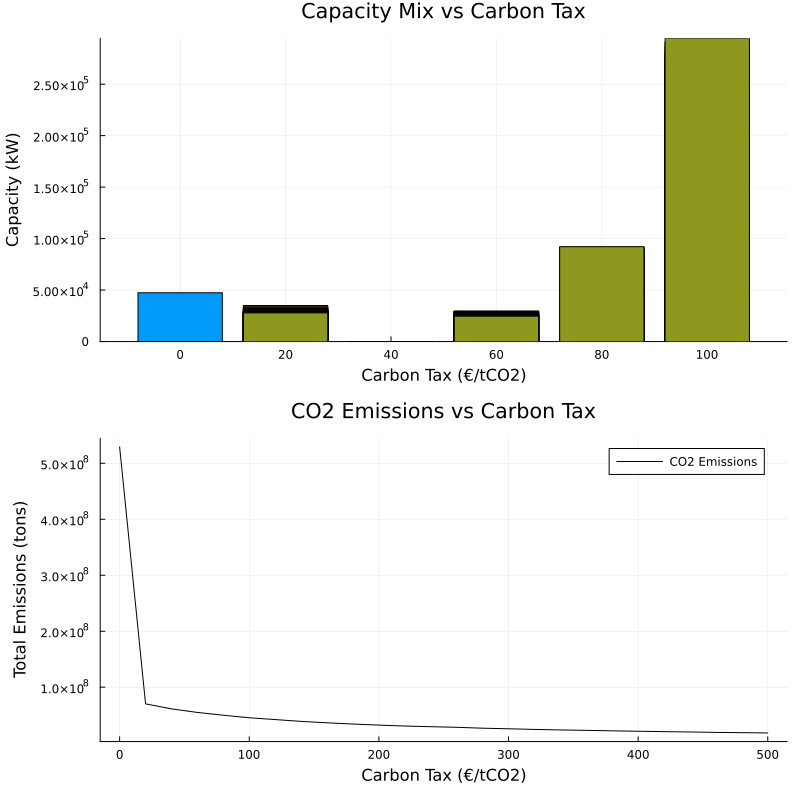

In [13]:
# Assuming 'technologies' dictionary keys are in a specific order, which should be maintained
tech_names = collect(keys(technologies))  # Make sure this is a stable, ordered collection
num_techs = length(tech_names)  # Number of different technologies

# Create a matrix where each row represents a technology, each column a carbon tax level
capacity_matrix = Array{Float64}(undef, num_techs, length(carbon_tax_levels))

for (tax_index, tax) in enumerate(carbon_tax_levels)
    for (tech_index, tech) in enumerate(tech_names)
        capacity_matrix[tech_index, tax_index] = capacities[tax_index][tech]  # Assign capacity for each technology at each tax level
    end
end

# Plotting
p1 = bar(capacity_matrix, label=tech_names, 
         title="Capacity Mix vs Carbon Tax", xlabel="Carbon Tax (€/tCO2)", ylabel="Capacity (kW)", 
         xticks=(1:length(carbon_tax_levels), string.(carbon_tax_levels)), stacked=true,legend=false) #legend=:outerright)
# retirer légende peut-être


p2 = plot(carbon_tax_levels, emissions, label="CO2 Emissions", color=:black,
          title="CO2 Emissions vs Carbon Tax", xlabel="Carbon Tax (€/tCO2)", ylabel="Total Emissions (tons)",
          legend=:topright)


# savefig(p1, "capacity_mix_vs_carbon_tax.png")  
# savefig(p2, "co2_emissions_vs_carbon_tax.png")  

plot(p1, p2, layout=(2, 1), size=(800, 800))
